## CartPole

The environment consists of a pole that is attached to a cart via a joint. Force can be applied to the cart in both horizontal directions. The goal is to keep the pole upright (less than 15 degrees from vertical) for as long as possible (while the timesteps were limited to 200 max for this training). The agent receives a reward of +1 for every timestep that it keeps the pole from falling over or moving the cart more than 2.4 units from the center.

In [1]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Constants
GAMMA = 0.9

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        return x 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action])
        return highest_prob_action, log_prob

In [2]:
def update_policy(policy_network, rewards, log_probs):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()

In [3]:
def main():
    env = gym.make('CartPole-v0')
    policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)
    
    max_episode_num = 5000
    max_steps = 10000
    numsteps = []
    avg_numsteps = []
    all_rewards = []

    for episode in range(max_episode_num):
        state = env.reset()
        log_probs = []
        rewards = []

        for steps in range(max_steps):
            env.render()
            action, log_prob = policy_net.get_action(state)
            new_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                update_policy(policy_net, rewards, log_probs)
                numsteps.append(steps)
                avg_numsteps.append(np.mean(numsteps[-10:]))
                all_rewards.append(np.sum(rewards))
                if episode % 1 == 0:
                    sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
                break
            
            state = new_state
        
    plt.plot(numsteps)
    plt.plot(avg_numsteps)
    plt.xlabel('Episode')
    plt.show()

episode: 0, total reward: 16.0, average_reward: 16.0, length: 15
episode: 1, total reward: 10.0, average_reward: 13.0, length: 9
episode: 2, total reward: 31.0, average_reward: 19.0, length: 30
episode: 3, total reward: 13.0, average_reward: 17.5, length: 12
episode: 4, total reward: 14.0, average_reward: 16.8, length: 13
episode: 5, total reward: 14.0, average_reward: 16.333, length: 13
episode: 6, total reward: 17.0, average_reward: 16.429, length: 16
episode: 7, total reward: 20.0, average_reward: 16.875, length: 19
episode: 8, total reward: 22.0, average_reward: 17.444, length: 21
episode: 9, total reward: 22.0, average_reward: 17.9, length: 21
episode: 10, total reward: 19.0, average_reward: 18.2, length: 18
episode: 11, total reward: 16.0, average_reward: 18.8, length: 15
episode: 12, total reward: 20.0, average_reward: 17.7, length: 19
episode: 13, total reward: 9.0, average_reward: 17.3, length: 8
episode: 14, total reward: 26.0, average_reward: 18.5, length: 25
episode: 15, to

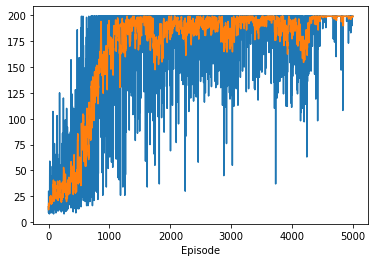

In [4]:
if __name__ == '__main__':
    main()

## References
- [Deriving Policy Gradients and Implementing REINFORCE - Chris Yoon](https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63)
- [OpenAI Gym Cartpole](https://gym.openai.com/envs/CartPole-v1)